In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import imblearn
from imblearn.over_sampling import SMOTE

In [30]:
!pip install imbalanced-learn
# установим библиотеку imbalanced-learn для создания 
# дублирующей выборки класса меньшинства (метод SMOTE)

In [1138]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

**Описания полей**

**client_id** - идентификатор клиента

**education** - уровень образования

**sex** - пол заемщика

**age** - возраст заемщика

**car** - флаг наличия автомобиля

**car_type** - флаг автомобиля иномарки

**decline_app_cnt** - количество отказанных прошлых заявок

**good_work** - флаг наличия “хорошей” работы

**bki_request_cnt** - количество запросов в БКИ

**home_address** - категоризатор домашнего адреса

**work_address** - категоризатор рабочего адреса

**income** - доход заемщика

**foreign_passport** - наличие загранпаспорта

**sna** - связь заемщика с клиентами банка

**first_time** - давность наличия информации о заемщике

**score_bki** - скоринговый балл по данным из БКИ

**region_rating** - рейтинг региона

**app_date** - дата подачи заявки

**default** - флаг дефолта по кредиту

### Обработка признаков.

Объединяем тренинговую и тестовую части в один датасет для совместной обработки признаков.

In [1139]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [1140]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [1141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [1142]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

#### Заполнение пропусков
Пропуски только в столбце образования (education). Зарплата зависит от уровня квалификации, поэтому посмотрим связь признаков education и income. 

education
ACD    85949.405498
GRD    54315.008916
PGR    79753.214477
SCH    32033.254681
UGR    39009.904868
Name: income, dtype: float64

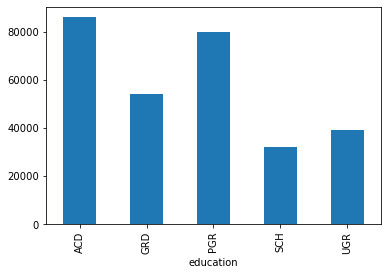

In [1145]:
data.groupby('education').income.mean().plot(kind = 'bar')
data.groupby('education').income.mean()

Заполним пропуски в образовании в разрезе дохода. Для этого напишем функцию.

In [1146]:
def edu_nan(row):
    """Функция проверяет доход клиента, у которого пропуск в образовании,
    и в зависимости от дохода подставляет уровень образования. Уровни отсечения -
    это средний доход по образовательной группе."""
    if pd.isnull(row['education']):
        if row['income'] < 32033:
            return 'SCH'
        if row['income'] < 39010:
            return 'UGR'
        if row['income'] < 54315:
            return 'GRD'
        if row['income'] < 79753:
            return 'PGR'
        else:
            return 'ACD'
    else:
        return row['education']        

In [1147]:
data['education'] = data.apply(edu_nan, axis = 1)
# Заполняем пробелы функцией.

In [1148]:
data.education.isnull().sum()
# Проверяем

0

#### Упорядочение переменной education
Education - это категориальная порядковая переменная, поэтому можно заменить строковый названия категорий числовыми значениями. 

1. SCH - school (среднее образование)
2. UGR - undergraduates (старшекурсник)
3. GRD - graduate (выпускник)
4. PGR - practice graduate (магистр+стажировка)
5. ACD - высшая категория образования

In [1149]:
data = data.replace({'education':{'SCH':1, 'UGR':2, 'GRD':3, 'PGR':4, 'ACD':5}})

#### Работа с типами признаков.
Датасет содержит бинарные, категориальные и цифровые признаки. Для простоты из совместной обработки сохраним списки этих переменных в отдельные переменные.

In [1150]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#### Числовые признаки - распределение
Посмотрим распределение числовых признаков

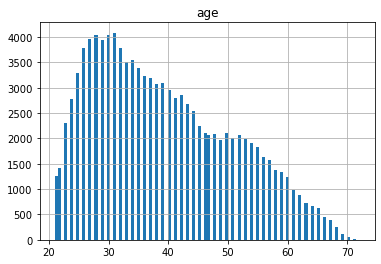

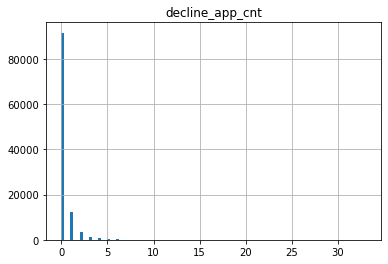

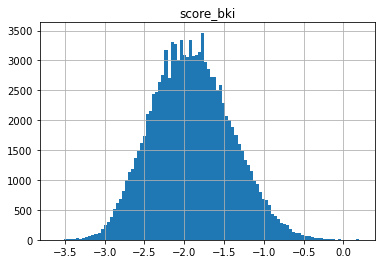

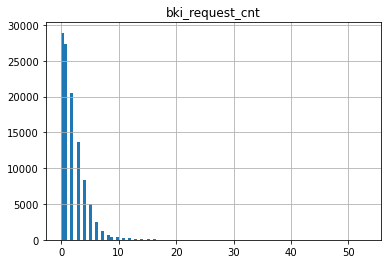

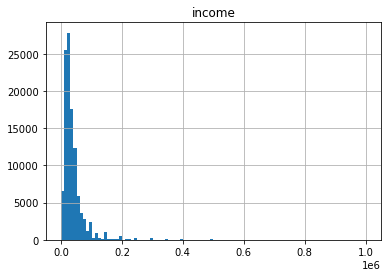

In [1151]:
for i in num_cols:
    # Используем цикл, чтобы создать распределения для всех признаков сразу.
    plt.figure()
    # Создаем новую плоскость для графика
    data[i].hist(bins = 100)
    # Рисуем в плоскости график
    plt.title(i)
    # Подписываем
    plt.show()
    # Показываем

Только признак score_bki имеет нормальное распределение, остальные числовые признаки имеют смещенное распределение с тяжелым правым хвостом. Для того чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. 

В признаках 'bki_request_cnt' и 'decline_app_cnt' имеются нулевые значения, поэтому перед логарифмированием увеличим каждое значение в этих переменных на 1, то есть сдвинем все значения вправо. Это не изменит соотношение величин между собой. 

In [1153]:
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data['age'] = np.log(data['age'])
data['income'] = np.log(data['income'])

Посмотрим распределение числовых признаков после логарифмирования.

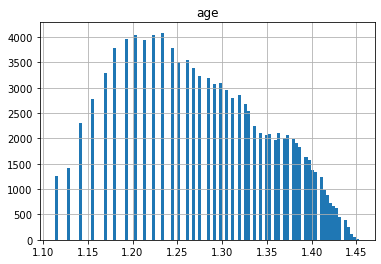

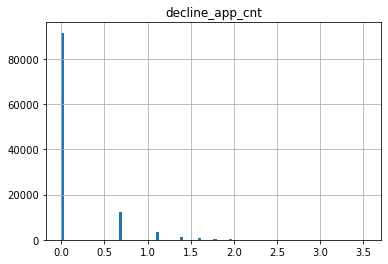

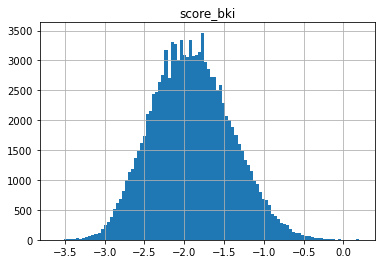

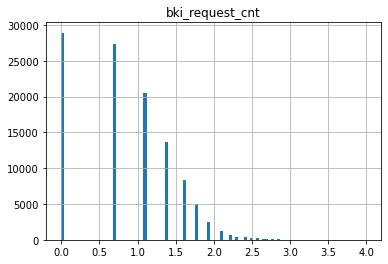

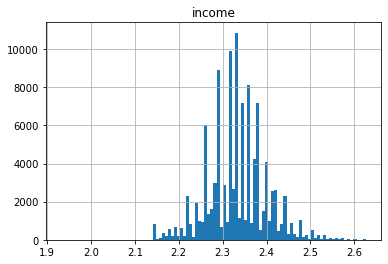

In [1154]:
for i in num_cols:
    # Используем цикл, чтобы создать распределения для всех признаков сразу.
    plt.figure()
    # Создаем новую плоскость для графика
    data[i].hist(bins = 100)
    # Рисуем в плоскости график
    plt.title(i)
    # Подписываем
    plt.show()
    # Показываем

После логарифмирования распределение признаков стало гораздо ближе к нормальному.

#### Числовые признаки - корреляция.
Проверим нет ли среди числовых признаков сильно скоррелированных.

In [1155]:
data[num_cols].corr()
# Все числовые переменные слабо скоррелированы между собой. 

,age,decline_app_cnt,score_bki,bki_request_cnt,income
age,1.000000,-0.130482,-0.110160,0.051850,-0.090123
decline_app_cnt,-0.130482,1.000000,0.207342,0.127531,-0.011682
score_bki,-0.110160,0.207342,1.000000,0.141600,0.004366
bki_request_cnt,0.051850,0.127531,0.141600,1.000000,0.079106
income,-0.090123,-0.011682,0.004366,0.079106,1.000000


<AxesSubplot:>

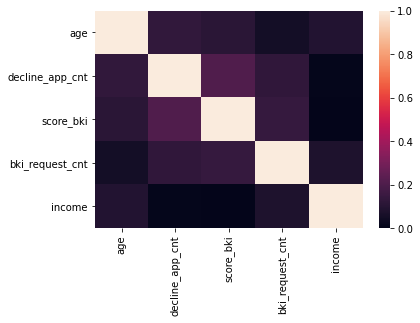

In [1156]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Среди числовых признаков нет сильно скоррелированных между собой.

#### Числовые признаки - значимость
Для возможного уменьшения размерности и улучшения предсказательной силы моделей проведем отбор важных признаков, чтобы знать от каких признаков можно отказаться. Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. В качестве меры значимости мы будем использовать значение f-статистики. 

In [1157]:
from sklearn.feature_selection import  f_classif 
# Импортируем нужную функцию.

<AxesSubplot:>

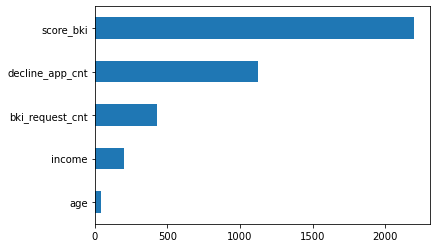

In [1158]:
imp_num = f_classif(data[num_cols], data['default'])[0]
# Функция возвращает2 массива.Берем только первый - f_statistic с индексом [0].
# Сохраняем этот массив в переменную.

imp_num = pd.Series(imp_num, index = num_cols)
# Переводим массив в серию для использования визуализации.

imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
# Выводим значения f_statistic (значимости признаков для целевой переменной) на диаграмме.

**Признак AGE самый мало значимый, поэтому его не включаем в модель.**

#### Бинарные признаки
Бинарные признаки в датасете почти все имеют строковые значения. Необходимо преобразовать признаки в числовые. Для этого воспользуемся уже готовыми библиотечными функциями. Для бинарных признаков мы будем использовать LabelEncoder

In [1159]:
for i in bin_cols:
    print([i], data[i].unique())

['sex'] ['M' 'F']
['car'] ['Y' 'N']
['car_type'] ['Y' 'N']
['good_work'] [0 1]
['foreign_passport'] ['N' 'Y']


In [1160]:
from sklearn.preprocessing import LabelEncoder
# Загружаем нужную функцию.

In [1161]:
le = LabelEncoder()
# Создаем объект - экземпляр класса .

for column in bin_cols:
    # Перебираем в цикле каждый бинарный признак.
    data[column] = le.fit_transform(data[column])
    # Присваиваем новые значения столбцам вызывая методы fit и transform класса LabelEncoder

In [1162]:
# убедимся в преобразовании    
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0
4,0,0,0,0,0


#### Категориальные признаки - значимость.
 Для оценки значимости числовых переменных будем использовать функцию mutual_info_classif из библиотеки sklearn.  

In [1163]:
from sklearn.feature_selection import mutual_info_classif
# Импортируем нужную функцию.

<AxesSubplot:>

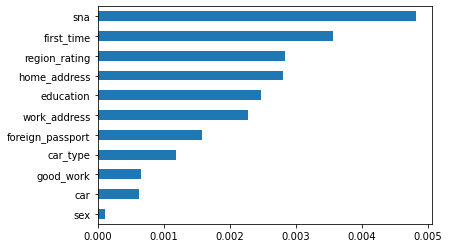

In [1164]:
imp_cat = mutual_info_classif(data[bin_cols + cat_cols ], data['default'], discrete_features =True)

imp_cat = pd.Series(imp_cat, index = bin_cols + cat_cols)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

**Признаки CAR и SEX самые мало значимые, поэтому их не включаем в модель.**

**С учетом значимости оставляем для модели только следующие признаки.**

In [1165]:
data = data[['score_bki', 'decline_app_cnt', 'bki_request_cnt',
            'education','region_rating','home_address','work_address',
           'sna','first_time','sample','default','foreign_passport',
              'car_type','good_work','income']]

In [1191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   score_bki         110148 non-null  float64
 1   decline_app_cnt   110148 non-null  float64
 2   bki_request_cnt   110148 non-null  float64
 3   education         110148 non-null  int64  
 4   region_rating     110148 non-null  int64  
 5   home_address      110148 non-null  int64  
 6   work_address      110148 non-null  int64  
 7   sna               110148 non-null  int64  
 8   first_time        110148 non-null  int64  
 9   sample            110148 non-null  int64  
 10  default           110148 non-null  int64  
 11  foreign_passport  110148 non-null  int32  
 12  car_type          110148 non-null  int32  
 13  good_work         110148 non-null  int64  
 14  income            110148 non-null  float64
dtypes: float64(4), int32(2), int64(9)
memory usage: 11.8 MB


**После обработки признаков обратно выделяем из датасета  обучающую и валидационную выборки.**

In [1180]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)
# По признаку sample выделяем нужные части, а самм признак удаляем.

#### Целевая переменная
Соотношение классов: клиенты допустившие дефолт - default = 1 и клиенты без дефолта - default = 0 , почти 1:7. Выборка плохо сбалансирована по классам.

In [1181]:
train_data.default[train_data.default == 0].count() / train_data.default[train_data.default == 1].count()

6.874413145539906

1     9372
0    64427
Name: default, dtype: int64

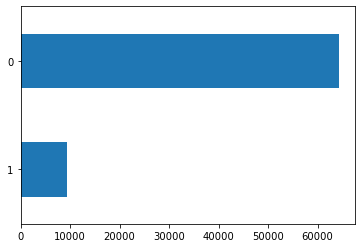

In [1182]:
train_data['default'].value_counts(ascending=True).plot(kind='barh')
train_data['default'].value_counts(ascending=True)

**Необходимо провести балансировку классов в тренировочных данных.**

**Обучающую выборку разделяем на матрицу признаков и целевую переменную.**

In [1183]:
y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1).values

In [1184]:
X.shape, y.shape

((73799, 13), (73799,))

#### Балансировка классов дефолтных и бездефолтных клиентов

In [1185]:
import imblearn
from imblearn.over_sampling import SMOTE
# Импортируем нужную библиотеку.

In [1186]:
oversample = SMOTE()
# Создаем экземпляр класса.
X, y = oversample.fit_resample(X, y)
# Вызываем метод класса.

In [1187]:
y[y==1].shape, y[y==0].shape
# Размеры классов 1 и 0 теперь одинаковы.

((64427,), (64427,))

### Обучающую выборку разбиваем на тренировочную и тестовую

In [1188]:
from sklearn.model_selection import train_test_split
# Импортируем нужную функцию.

In [1189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Размер тестовой выборки 20%.

In [1190]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((103083, 13), (25771, 13), (103083,), (25771,))

#### Нормализация числовых ризнаков в тренировочной матрице признаков

In [1192]:
from sklearn.preprocessing import StandardScaler
# Загружаем нужную функцию из библиотеки

scaler = StandardScaler()
# Создаем объект scaler, который расчитает параметры нормализации для набора признаков X 
# и будет хранить параметры нормализации для последующих данных.

In [1193]:
X_train[:, [1, 2, 3]] = scaler.fit_transform(X_train[:, [1, 2, 3]])

### Обучение модели

In [1194]:
from sklearn.linear_model import LogisticRegression
# Импортируем инструмент для создания и обучения модели

In [1195]:
logreg = LogisticRegression(solver = 'liblinear', max_iter = 1000, class_weight='balanced')
# Создаем модель. Количество итераций - 1000.

In [1196]:
logreg.fit(X_train, y_train)
# Обучаем модель

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

### Предсказываем значения целевой переменной при помощи обученной модели.

In [1197]:
y_pred = logreg.predict(X_test)

### Оцениваем модель по метрикам

In [1198]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6641185829032633
0.6821385593948771
0.6154800682487979
0.6470971950424006


### Обучение модели на всей обучающей выборке
Если метрики качества модели на предыдущем этапе устраивают, то обучаем модель на всей обучающей выборке, то есть берем для обучения не только X_train и y_train, а целиком X и y.

In [1200]:
# Проводим стандартизацию числовых признаков всей обучающей выборки.
scaler = StandardScaler()
X[:, [1, 2, 3]] = scaler.fit_transform(X[:, [1, 2, 3]])

In [1202]:
logreg_final = LogisticRegression(solver='liblinear', max_iter=1000)
# Создаем модель.
logreg_final.fit(X, y)
# Обучаем модель.
predict_submission = logreg_final.predict(np.array(test_data))
# Предсказываем целевую переменную.

In [1204]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [1205]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.326611
std,31706.052195,0.468980
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000
